# Export training data Delta

Here we will convert our training data in the format Delta needs for processing

In [1]:
from delta.data import seg_weights_2D
import pathlib
import h5py
import numpy as np
import tifffile

import dask.array as da


In [36]:
#read data
root = pathlib.Path(pathlib.Path.home(), 'home', 'Delta2_Caulobacter')
data_dir = root / 'data'

training_file = data_dir /  'training_data_delta.hdf5'

with h5py.File(training_file, 'r') as f:
    chuck_size = (1, *f['mask_train'].shape[-2:])
    mask_train = np.array(f['mask_train'])
    mask_valid = np.array(f['mask_valid'])
    image_train = np.array(f['image_train'])
    image_valid = np.array(f['image_valid'])    

#convert to dask arrays for parallel processing    
mask_valid = da.from_array(mask_valid, chunks=chuck_size)  
mask_train = da.from_array(mask_train, chunks=chuck_size)  

In [37]:
#need wrapper function of delta.data.seg_weights_2D() to return 3D array
def calc_weigths(a): 
    return seg_weights_2D(np.squeeze(a))[np.newaxis, :, :]  

In [38]:
#calculate mask weights
weight_train = da.map_blocks(calc_weigths, mask_train, dtype='float32')
weight_valid = da.map_blocks(calc_weigths, mask_valid, dtype='float32')


In [39]:
#force computation
weight_train = weight_train.compute()
weight_valid = weight_valid.compute()
print(weight_train.shape)
print(weight_valid.shape)

(91, 1024, 1024)
(23, 1024, 1024)


In [45]:
def augment_matrix(array):
    #1 / lr / ud / lr&up transformations
    array = np.concatenate((array, np.flip(array, axis=1), np.flip(array, axis=2), np.flip(np.flip(array, axis=1),axis=2)), axis = 0)
    #add 90degree turn
    return np.concatenate((array, np.rot90(array, axes=(1,2))), axis=0)
    

In [46]:
#augment validation data
mask_valid_aug = augment_matrix(mask_valid)
img_valid_aug = augment_matrix(image_valid)
wei_valid_aug = augment_matrix(weight_valid)

#shuffle validation data
rng = np.random.default_rng()
idx = rng.permutation(mask_valid_aug.shape[0])

mask_valid_aug = mask_valid_aug[idx,:,:]
img_valid_aug = img_valid_aug[idx,:,:]
wei_valid_aug = wei_valid_aug[idx,:,:]


mask_valid_aug.shape

(184, 1024, 1024)

In [48]:
#define export function
def export_data(path, image, mask, weight):
    (path / 'img').mkdir(exist_ok=True)
    (path / 'seg').mkdir(exist_ok=True)
    (path / 'wei').mkdir(exist_ok=True)

    for idx, (im, mask, wei) in enumerate(zip(image, mask, weight)):
        im_name = path / 'img' / ('img_%04i.tif' % idx)
        lab_name = path / 'seg' / ('img_%04i.tif' % idx)
        wei_name = path / 'wei' / ('img_%04i.tif' % idx)
        
        tifffile.imwrite(im_name, im)
        tifffile.imwrite(lab_name, mask)
        tifffile.imwrite(wei_name, wei)    
    return None

In [8]:
#export training data to tiff   
training_set = data_dir / 'training'
training_set.mkdir(exist_ok=True)
export_data(training_set, image_train, mask_train, weight_train)


In [49]:
#export validation data
validation_set = data_dir / 'validation'
validation_set.mkdir(exist_ok=True)
export_data(validation_set, image_valid, mask_valid, weight_valid)

In [51]:
import matplotlib.pyplot as plt

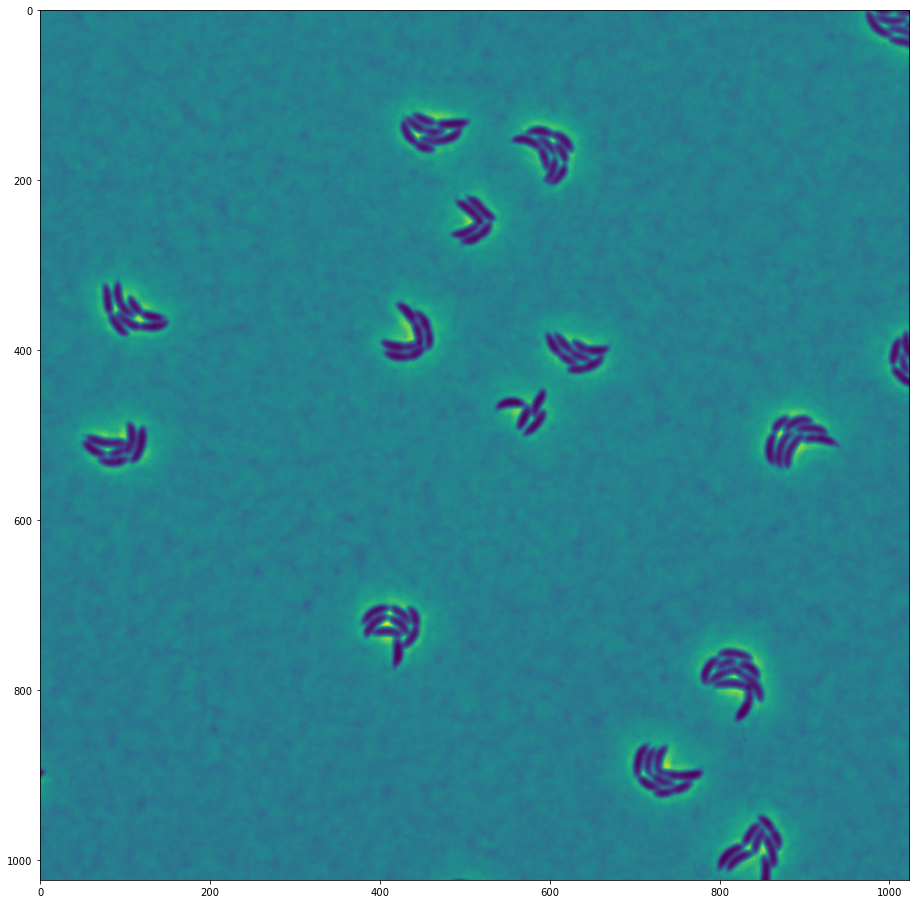

In [55]:
fig, axs = plt.subplots(figsize=(16,16))
axs.imshow(img_valid_aug[15,:,:])